In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import geopandas as gpd
import numpy as np
import timeit

(2201466.728842696, 2251903.4973147013, 6440043.130753223, 6468528.844798662)

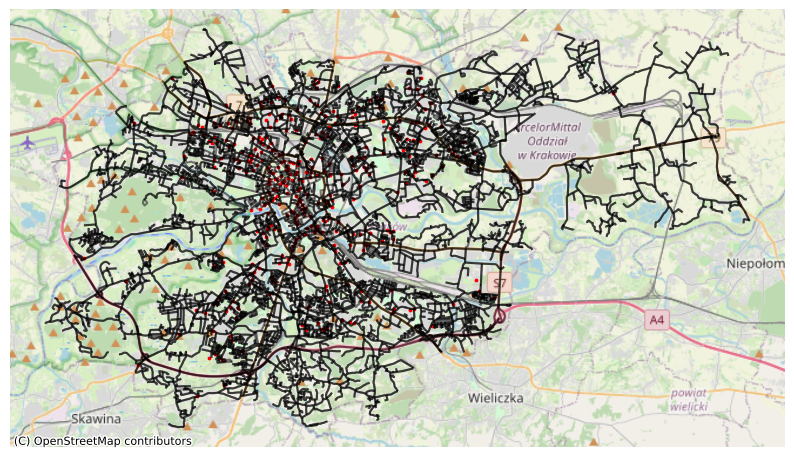

In [3]:
zabki_gdf = gpd.read_file('zabki_krakow.geojson')
zabki_gdf = zabki_gdf.to_crs(epsg=4326)
nearest_gdf = gpd.read_file('nearest.geojson')
neares_gdf = nearest_gdf.to_crs(epsg=4326)

import osmnx as ox

G = ox.graph_from_place('Kraków, Poland', network_type='drive')
# Utworzenie GeoDataFrame z ulicami 
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)


#plot map of Krakow
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=1, markersize=3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

Finalna mapa Żabek i ulic w Krakowie

In [4]:
# Interaktywna mapa z ulicami, sklepami Żabka i najbliższymi punktami
import folium
from folium.plugins import MarkerCluster
import webbrowser

m = folium.Map(location=[50.0667, 19.9333], zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for i, row in zabki_gdf.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup='Żabka ID:' + '<br>' +str(row['id'])).add_to(marker_cluster)

for i, row in streets_gdf.iterrows():
    coords = list(row['geometry'].coords)
    locations = [(y, x) for x, y in coords]
    folium.PolyLine(locations=locations, color='black').add_to(m)

for i, row in nearest_gdf.iterrows():
    idx = row['id']
    nearest_point = row['geometry']
    folium.PolyLine(locations=[(zabki_gdf[zabki_gdf['id'] == idx]['lat'].values[0], zabki_gdf[zabki_gdf['id'] == idx]['lon'].values[0]),
                                (nearest_point.y, nearest_point.x)], color='red').add_to(m)
    
    folium.Marker(location=[nearest_point.y, nearest_point.x], popup='Nearest point to Żabka ID:' + '<br>' +str(row['id']) + '<br>' + 'Distance: ' + str(round(row['distance'], 2)) + ' m').add_to(m)


m.save('zabki_and_streets.html')
webbrowser.open('zabki_and_streets.html')

True

In [13]:
distance_matrix_df = pd.read_csv('distance_matrix.csv', index_col=0)
distance_matrix_straigt_line_df = pd.read_csv('distance_matrix_straight_line.csv', index_col=0)
# path_matrix_df = pd.read_pickle('path_matrix_df.pkl')

In [14]:
# Zamieńmy wartości na km z dokładnością do metra
distance_matrix_df = distance_matrix_df / 1000
distance_matrix_df = distance_matrix_df.round(3)

distance_matrix_straigt_line_df = distance_matrix_straigt_line_df / 1000
distance_matrix_straigt_line_df = distance_matrix_straigt_line_df.round(3)


# Szukanie najkrótszej trasy algorytmem genetycznym

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [15:11<00:00,  2.74it/s]


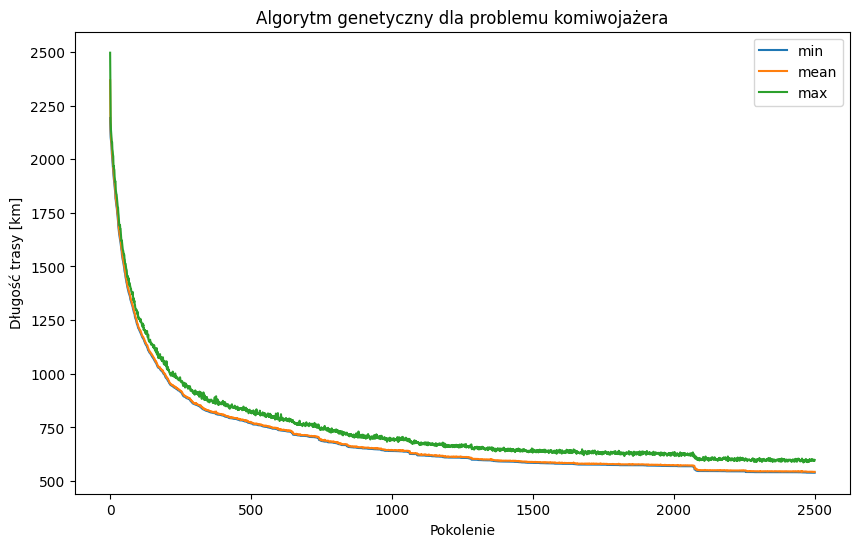

In [4]:
class TSP:
    def __init__(self, dist_matrix, pop_size=100, cxpb=0.5, mutpb=0.2, ngen=100):
        self.dist_matrix = dist_matrix # macierz odległości
        self.pop_size = pop_size # rozmiar populacji
        self.cxpb = cxpb # prawdopodobieństwo krzyżowania 
        self.mutpb = mutpb # prawdopodobieństwo mutacji
        self.ngen = ngen # liczba pokoleń
        self.size = dist_matrix.shape[0] # Rozmiar chromosomu
        self.best_ind = None # najlepsze rozwiązanie (trasa)
        self.best_ind_fitness = np.inf # wartość funkcji celu dla najlepszego rozwiązania (długość trasy)
        self.pop = self.init_pop()
        self.stats = pd.DataFrame(columns=['min', 'mean', 'max'], index=range(ngen))
        self.stats.index.name = 'gen'


    def init_pop(self):
        pop = np.zeros((self.pop_size, self.size), dtype=int)
        for i in range(self.pop_size):
            pop[i] = np.random.permutation(self.size) 
        return pop


    # def evaluate(self, ind):
    #     return np.sum([self.dist_matrix[ind[i], ind[i + 1]] for i in range(len(ind) - 1)]) # obliczenie długości trasy dla danego osobnika na podstawie macierzy odległości
    def evaluate(self, ind): # szybsza wersja funkcji oceny
        return np.sum(self.dist_matrix[ind, np.roll(ind, -1)])


    def cx(self, ind1, ind2):
        
        cx_point1 = np.random.randint(0, self.size)
        cx_point2 = np.random.randint(0, self.size - 1)

        if cx_point2 >= cx_point1:
            cx_point2 += 1
        else: # Swap the two cx points
            cx_point1, cx_point2 = cx_point2, cx_point1

        cutout = ind1[cx_point1:cx_point2].copy()
        ind1 = [x for x in ind2 if x not in cutout]
        ind1[cx_point1:cx_point1] = cutout
        return ind1, ind2


    def mutate(self, ind):
        mut_point1 = np.random.randint(0, self.size)
        mut_point2 = np.random.randint(0, self.size)
        ind[mut_point1], ind[mut_point2] = ind[mut_point2], ind[mut_point1]
        return ind
    
    
    def select(self, pop, fits):
        return pop[np.argsort(fits)]


    def evolve(self):
        for gen in tqdm.tqdm(range(self.ngen)):
            fits = np.array([self.evaluate(ind) for ind in self.pop])
            temp_min = np.min(fits)
            self.stats.loc[gen] = [temp_min, np.mean(fits), np.max(fits)]
            if temp_min < self.best_ind_fitness: # Znaleziono lepsze rozwiązanie
                self.best_ind = self.pop[np.argmin(fits)].copy()
                self.best_ind_fitness = temp_min
            next_pop = np.zeros_like(self.pop)
            for i in range(0, self.pop_size, 2): 
                ind1, ind2 = self.select(self.pop, fits)[:2] # Selekcja 2 najlepszych osobników (rankingowa)
                if np.random.rand() < self.cxpb:
                    ind1, ind2 = self.cx(ind1, ind2)    
                if np.random.rand() < self.mutpb:
                    ind1 = self.mutate(ind1)
                if np.random.rand() < self.mutpb:
                    ind2 = self.mutate(ind2)
                next_pop[i] = ind1
                next_pop[i + 1] = ind2
            self.pop = next_pop
        return self.best_ind, self.best_ind_fitness, self.stats


    def plot_stats(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.lineplot(data=self.stats, x='gen' , y='min', label='min')
        sns.lineplot(data=self.stats, x='gen', y='mean', label='mean')
        sns.lineplot(data=self.stats, x='gen', y='max', label='max')
        plt.xlabel('Pokolenie')
        plt.ylabel('Długość trasy [km]')
        plt.title('Algorytm genetyczny dla problemu komiwojażera')
        plt.legend()
        plt.show()


tsp = TSP(distance_matrix_df.values, pop_size=1000, cxpb=0.5, mutpb=0.2, ngen=2500)
best_ind, best_ind_fitness, stats = tsp.evolve()
tsp.plot_stats()

In [5]:
print('Długość trasy:', best_ind_fitness, 'km')
stats

Długość trasy: 538.94 km


,min,mean,max
gen,,,
0,2191.974,2367.928238,2496.187
1,2130.896,2210.965223,2310.394
2,2099.937,2135.831574,2173.813
3,2087.222,2104.405181,2136.609
4,2075.344,2089.610588,2116.303
...,...,...,...
2495,538.94,542.754603,599.632
2496,538.94,542.303615,594.302
2497,538.94,542.984878,595.244


In [6]:
import collections

def validate_TSP_path(path):
    if len(path) != distance_matrix_df.shape[0]:
        print('Nie wszystkie punkty w trasie')
        return False
    #sprawdź czy są duplikaty
    if len(path) != len(set(path)):
        print('Duplikaty w trasie')
        print([item for item, count in collections.Counter(path).items() if count > 1])
        return False
    #sprawdź czy są punkty od 0 do n-1
    if set(path) != set(range(distance_matrix_df.shape[0])):
        print('Nie wszystkie punkty od 0 do n-1')
        return False
    
    return True


validate_TSP_path(best_ind)

True

# Bardziej wydajny algorytm z wykorzystaniem bibilioteki DEAP

gen	nevals	avg    	min    	max    
0  	1000  	2367.82	2227.47	2512.96
1  	577   	2336.4 	2226.64	2470.43
2  	611   	2313.47	2195.82	2446.83
3  	642   	2297   	2184.56	2437.46
4  	587   	2278.52	2164.12	2391.82
5  	575   	2264.18	2180.82	2380.06
6  	598   	2254.05	2172.75	2381.6 
7  	581   	2239.61	2124.91	2349.26
8  	574   	2228.95	2114   	2363.07
9  	604   	2218.49	2117.11	2369.87
10 	620   	2209.45	2102.46	2358.45
11 	592   	2199.36	2101.33	2384.02
12 	595   	2190.12	2092.79	2340.04
13 	600   	2182.02	2047.06	2339.51
14 	596   	2171.82	2071.95	2339.19
15 	612   	2164.88	2071.95	2309.08
16 	567   	2156.39	2053.38	2323.73
17 	607   	2153.29	2046.84	2301.47
18 	577   	2143.98	2046.84	2298.26
19 	603   	2136.02	2009.83	2302.75
20 	597   	2126.87	2001.47	2278.3 
21 	594   	2122.15	2001.47	2280.99
22 	609   	2112.59	2001.47	2272.5 
23 	627   	2106.98	2001.47	2265.49
24 	606   	2100.19	1982.22	2252.13
25 	574   	2093.15	1982.22	2293.13
26 	606   	2085.51	1983.51	2220.35
27 	588   	2078.84	1

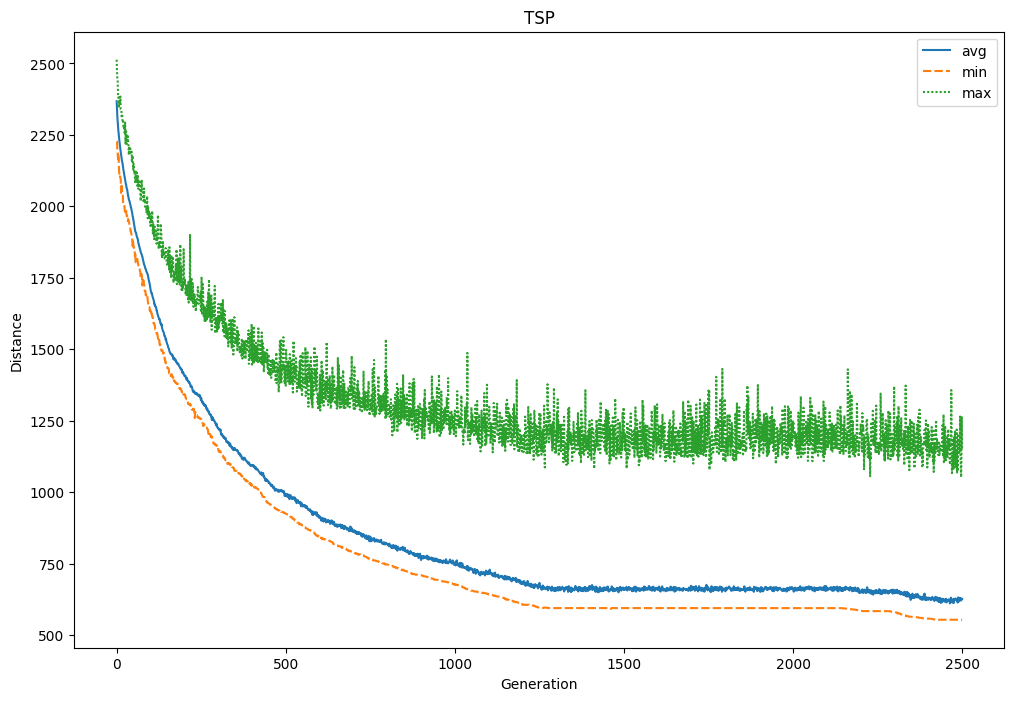

In [7]:
import random
from deap import base, creator, tools, algorithms

class TSP:
    def __init__(self, dist_matrix, pop_size=100, cxpb=0.5, mutpb=0.2, ngen=100):
        self.dist_matrix = dist_matrix
        self.pop_size = pop_size
        self.cxpb = cxpb
        self.mutpb = mutpb
        self.ngen = ngen
        self.toolbox = self.create_toolbox() 
        self.pop = self.toolbox.population(n=self.pop_size)
        self.hof = tools.HallOfFame(1)
        self.stats = tools.Statistics(lambda ind: ind.fitness.values)
        self.stats.register('avg', np.mean)
        self.stats.register('min', np.min)
        self.stats.register('max', np.max)
        self.stats_df = pd.DataFrame(columns=['gen', 'nevals', 'avg', 'min', 'max'])
        
    def create_toolbox(self):
        creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
        creator.create('Individual', list, fitness=creator.FitnessMin)
        
        toolbox = base.Toolbox()
        toolbox.register('indices', random.sample, range(len(self.dist_matrix)), len(self.dist_matrix))
        toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.indices)
        toolbox.register('population', tools.initRepeat, list, toolbox.individual)
        toolbox.register('mate', tools.cxOrdered)
        toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.05)
        toolbox.register('select', tools.selTournament, tournsize=3)
        toolbox.register('evaluate', self.evaluate)
        
        return toolbox
    
    def evaluate(self, individual):
        return np.sum(self.dist_matrix[individual, np.roll(individual, -1)]),
    
    def run(self):
        pop, logbook = algorithms.eaSimple(self.pop, self.toolbox, cxpb=self.cxpb, mutpb=self.mutpb, ngen=self.ngen, stats=self.stats, halloffame=self.hof, verbose=True)
        self.stats_df = pd.DataFrame(logbook)
        self.stats_df.set_index('gen', inplace=True)
        return pop, self.hof, self.stats_df
    
    def plot_stats(self):
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=self.stats_df[['avg', 'min', 'max']])
        plt.xlabel('Generation')
        plt.ylabel('Distance')
        plt.title('TSP')
        plt.show()


tsp = TSP(distance_matrix_df.values, pop_size=1000, cxpb=0.5, mutpb=0.2, ngen=2500)

start = timeit.default_timer()
pop, hof, stats_df = tsp.run()
stop = timeit.default_timer()
def pretty_time_print(time):
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    miliseconds = int((time - int(time)) * 1000)
    return f'{hours}h {minutes}m {seconds}s {miliseconds}ms'

print('Time: ', pretty_time_print(stop - start))
tsp.plot_stats()


In [8]:
print('Best distance: ', hof[0].fitness.values[0], 'km')

validate_TSP_path(hof[0])

Best distance:  553.973 km


True

Jak możemy zobaczyć algorytm ten znalazł minimalnie gorsze rozwiązanie, jednak w czasie 3 razy krótszym od wcześniejszej implementacji

c:\Users\bugaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\bugaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	min    	max    
0  	5000  	2366.62	2217.53	2534.09
1  	2992  	2334.15	2147.19	2492.19
2  	3044  	2309.54	2147.19	2455.97
3  	3034  	2289.17	2170.31	2424.27
4  	2955  	2272.62	2144.85	2421.24
5  	2952  	2258.16	2144.85	2419.72
6  	3003  	2245.82	2128.57	2414.82
7  	3070  	2235.79	2118.64	2385.08
8  	2954  	2223.54	2112.49	2353.47
9  	2984  	2214.62	2067.32	2372.45
10 	3016  	2204.62	2067.32	2374.65
11 	3016  	2195.08	2057.41	2366.18
12 	2972  	2187.28	2057.41	2371.4 
13 	3023  	2177.6 	2050.61	2348.63
14 	2951  	2169.5 	2050.61	2344.26
15 	3003  	2161.01	2037.72	2341.31
16 	2987  	2152.23	2037.72	2319.5 
17 	2986  	2142.89	2019.6 	2304.39
18 	3025  	2133.69	2019.6 	2310.27
19 	3018  	2124.67	1987.64	2331.44
20 	3062  	2117.06	1996.72	2309.14
21 	2983  	2108.75	1986.36	2280.79
22 	2982  	2101.59	1960.57	2318.14
23 	2957  	2092.86	1960.57	2303.38
24 	2926  	2084.48	1960.57	2287.99
25 	2909  	2076.76	1960.57	2290.24
26 	3083  	2071.86	1960.57	2274.65
27 	3019  	2065.15	1

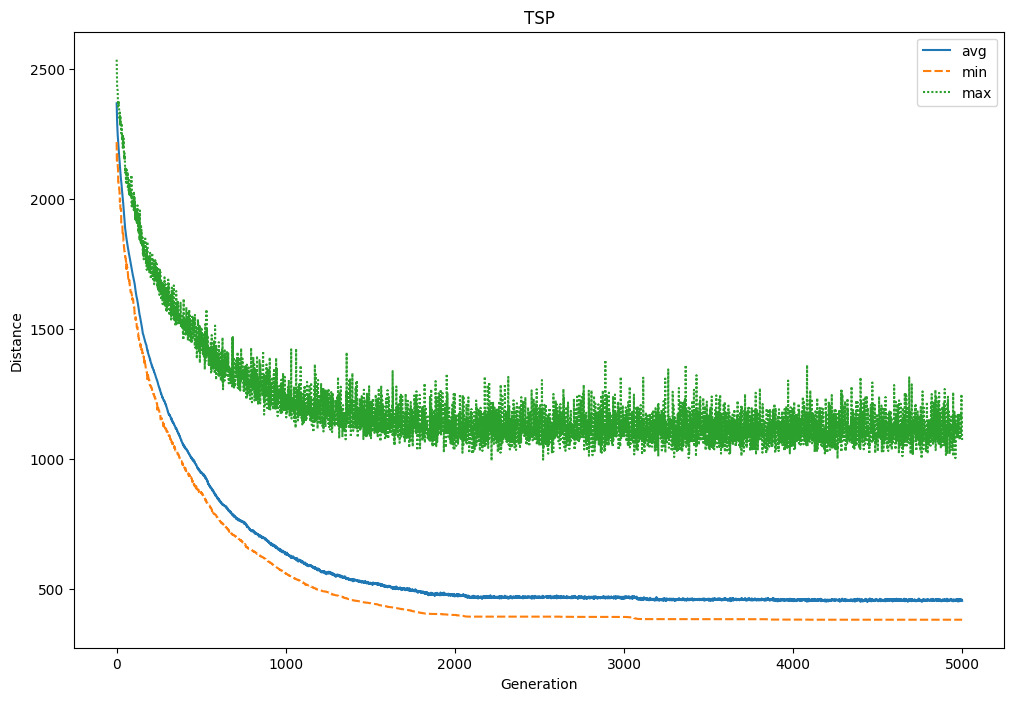

In [9]:
tsp = TSP(distance_matrix_df.values, pop_size=5000, cxpb=0.5, mutpb=0.2, ngen=5000)

start = timeit.default_timer()
pop, hof, stats_df = tsp.run()
stop = timeit.default_timer()
def pretty_time_print(time):
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    miliseconds = int((time - int(time)) * 1000)
    return f'{hours}h {minutes}m {seconds}s {miliseconds}ms'

print('Time: ', pretty_time_print(stop - start))
tsp.plot_stats()

In [11]:
#zapisz najlepszą trasę
best_path = hof[0]
best_path_df = pd.DataFrame(best_path, columns=['id'])
best_path_df.to_csv('best_path_5k_5k.csv', index=False)

Przeprowadźmy te same oblicze ale dla odległości w liniach prostych.

c:\Users\bugaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\bugaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	min    	max    
0  	5000  	1885.13	1760.23	2025.79
1  	2979  	1856.42	1725.68	1994.47
2  	3049  	1835.99	1725.68	1959.56
3  	2970  	1819.13	1710.7 	1938.79
4  	3050  	1805.66	1703.45	1931.48
5  	2950  	1792.75	1688.68	1939.01
6  	2996  	1782.45	1695.22	1923.7 
7  	3052  	1771.96	1668.3 	1932.59
8  	3009  	1761.48	1646.23	1899.63
9  	3001  	1750.68	1619.24	1896.35
10 	3021  	1741.63	1623.48	1888.34
11 	3053  	1732.26	1629.69	1875.99
12 	3033  	1725.07	1623.1 	1867.25
13 	2996  	1717.34	1623.45	1857.55
14 	2995  	1709.49	1597.63	1859.19
15 	2931  	1701.09	1591.16	1853.53
16 	2992  	1693.44	1591.16	1834.73
17 	3032  	1687.28	1589.92	1872.51
18 	3011  	1680.74	1572.28	1819.22
19 	3011  	1673.79	1572.28	1827.39
20 	3039  	1667.51	1570.1 	1812.68
21 	3013  	1662.95	1566.83	1855.82
22 	3074  	1658   	1549.59	1847.43
23 	2996  	1652.42	1542.53	1817.32
24 	2947  	1647.32	1529.32	1828.4 
25 	2977  	1640.86	1496.12	1804.85
26 	3020  	1634.86	1496.12	1792.21
27 	3035  	1628.55	1

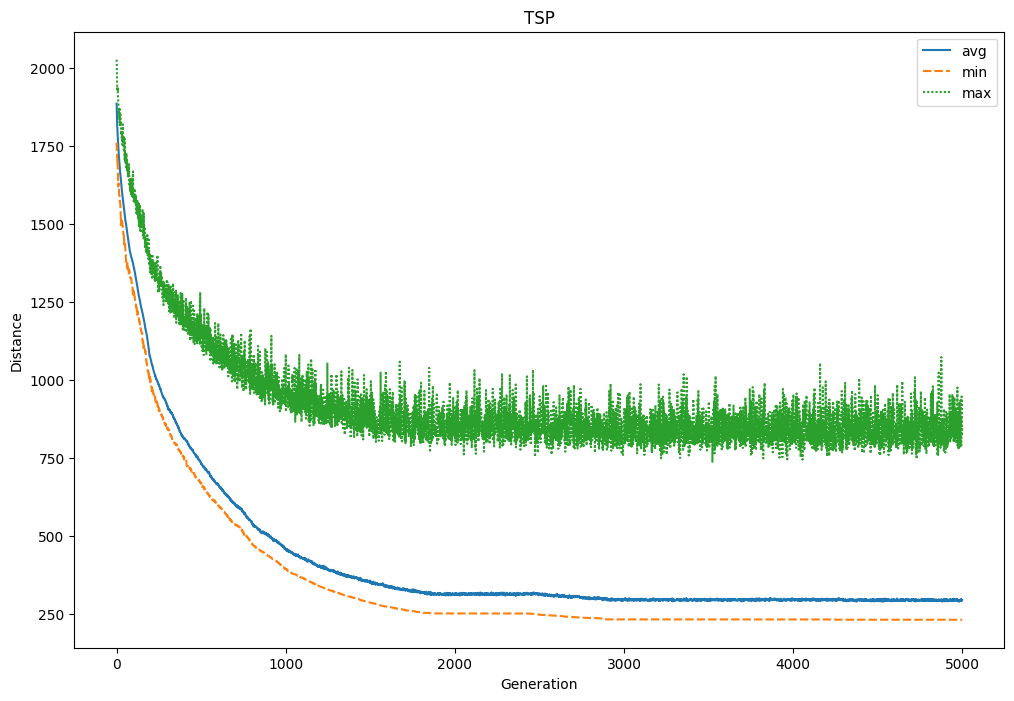

In [17]:
tsp = TSP(distance_matrix_straigt_line_df.values, pop_size=5000, cxpb=0.5, mutpb=0.2, ngen=5000)

start = timeit.default_timer()
pop, hof, stats_df = tsp.run()
stop = timeit.default_timer()
def pretty_time_print(time):
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    miliseconds = int((time - int(time)) * 1000)
    return f'{hours}h {minutes}m {seconds}s {miliseconds}ms'

print('Time: ', pretty_time_print(stop - start))
tsp.plot_stats()

In [18]:
best_path_straight_line = hof[0]
best_path_straight_line_df = pd.DataFrame(best_path_straight_line, columns=['id'])
best_path_straight_line_df.to_csv('best_path_straight_line_5k_5k.csv', index=False)